# Multitask GP Regression

## Introduction

This notebook demonstrates how to perform multi-task regression using functional kernel learning by sharing the latent Gaussian processes across tasks. The idea of sharing hyper-parameters across tasks in GP regression is not new and dates back to at least Mackay's textbook on information theory; however, it is particularly interesting in the FKL setting as the hyper-parameters are quite meaningful.

See Chapter ... of Mackay and Section 3 of FKL.

In [19]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%pdb

Automatic pdb calling has been turned ON


### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [3]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [4]:
train_y.shape

torch.Size([100, 2])

In [5]:
### Defining the models


In [6]:

class SpectralModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, **kwargs):
        from spectralgp.kernels import SpectralGPKernel

        super(SpectralModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = SpectralGPKernel(**kwargs)

        self.covar_module.initialize_from_data(train_x, train_y, **kwargs)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



##### The latent models

The model provided by `spectralgp.models.SpectralModel` takes in a latent model and latent likelihood to define the GP over the log-spectral density. In the multi-task setting this latent model is shared among tasks, so we only need a single one. 

The simplest thing to do here is to allow the `SpectralModel` instances handle the data-dependent initialization of the latent model, so we define the latent model and likelihood as `None`, then redefine and pass them through to the next data dimension. The ensures that each output dimension has an appropriately initialized latent model and that the latent model is shared correctly

In [7]:
latent_lh = None
latent_mod = None

##### The Data Models
Define the lists of data models and likelihoods (one for each task), passing in the training data and shared latent model for each one

In [8]:
data_lh_list = []
data_mod_list = []
for dim in range(train_y.shape[-1]):
    lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
    
    data_lh_list.append(lh)
    data_mod_list.append(SpectralModel(train_x, train_y[:,dim], likelihood=lh,
                                                        latent_mod=latent_mod, latent_lh=latent_lh, nomg = 100,
                                      omega_max = 8.))
    
    latent_mod = data_mod_list[dim].covar_module.latent_mod
    latent_lh = data_mod_list[dim].covar_module.latent_lh

(1e-10, 8.0)
(1e-10, 8.0)


### Defining the Samplers

***Gradient updates*** remain largely the same from the single-task setting, we need to define a single factory that handles creating loss functions for the hyperparameters of the model. 

***Elliptical slice sampling*** must happen differently than the 1-D case, since we need samples of the spectral densities corresponding to the kernel of each output dimension. Thus we make a list of factories that each defines a likelihood function of the spectral densities based on the data from that output dimension. Within each dimension the `ess_factory` initialization remains the same, so it's just a simple list comprehension of calls that are exactly like the 1-D case.

***The alternating sampler*** takes in the factories as defined above and runs in the same fashion as the single task case. For the multi-task case we provide the `spectralgp.samplers.GibbsAlternatingSampler` to handle generating updates to the hyperparameters and latent GP.

As usual we need to choose the total number of iterations as well as the number of SGD updates and ESS samples per iteration

In [9]:
total_iters = 1
sgd_iters = 5
ess_iters = 20

In [10]:
alt_sampler = gpytorch.samplers.AlternatingSampler(data_mod_list, data_lh_list,
                        gpytorch.samplers.ss_multmodel_factory,
                        [gpytorch.samplers.ess_factory] * train_y.shape[-1],
                        numInnerSamples=ess_iters, numOuterSamples=sgd_iters, totalSamples=total_iters,
                        num_dims=1, num_tasks=train_y.shape[-1]     
                        )

In [11]:
alt_sampler.run()

Task: 0 ; Iteration 0
Task: 1 ; Iteration 0
Seconds for Iteration 0 : 4.234530925750732


In [12]:
test_x = torch.linspace(0, 2, 101)

In [13]:
n_samples = 10 # take the last 10 sampled latent GPs from each station

pred_data = torch.zeros(train_y.shape[-1], len(test_x), n_samples)
lower_bds = torch.zeros(train_y.shape[-1], len(test_x), n_samples)
upper_bds = torch.zeros(train_y.shape[-1], len(test_x), n_samples)

In [14]:
for stn in range(train_y.shape[-1]):
    samples = alt_sampler.gsampled[0][stn, :, -n_samples:].detach()
    data_mod = data_mod_list[stn]
    data_lh = data_lh_list[stn]
    
    for ii in range(n_samples):
        data_mod.covar_module.set_latent_params(samples[:, ii])
        data_mod.set_train_data(train_x, train_y[:, stn]) # just to clear out the cache
        data_mod.eval()
        
        out = data_lh(data_mod(test_x))
        lower_bds[stn, :, ii], upper_bds[stn, :, ii] = out.confidence_region()
        pred_data[stn, :, ii] = out.mean
    
lower_bds = lower_bds.detach().numpy()
upper_bds = upper_bds.detach().numpy()
pred_data = pred_data.detach().numpy()
test_x = test_x.numpy()

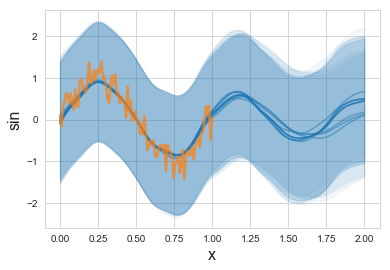

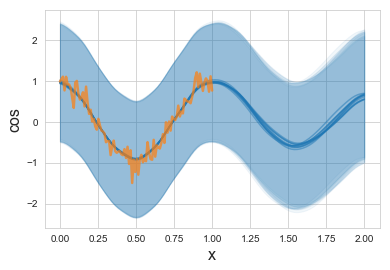

In [24]:
colors = cm.get_cmap("tab10")
sns.set_style("whitegrid")
sns.despine()

names = ['sin', 'cos']
for stn in range(train_y.shape[-1]):
    for ii in range(n_samples):
        if ii == 0:
            # plot with labels
            plt.plot(test_x, pred_data[stn, :, ii], color=colors(0), alpha=0.5,
                     label="Mean Prediction")
            plt.fill_between(test_x, lower_bds[stn,:,ii], upper_bds[stn,:,ii],
                             color=colors(0),alpha=0.06,
                             label=r'$\pm2$ SD')
        else:
            # plot without labels 
            plt.plot(test_x, pred_data[stn, :, ii], color=colors(0), alpha=0.5)
            plt.fill_between(test_x, lower_bds[stn,:,ii], upper_bds[stn,:,ii],
                             color=colors(0),alpha=0.06)
    plt.plot(train_x.numpy(), train_y[:, stn].numpy(), color=colors(1),
             alpha=0.7, linewidth=2.5,
             label="Train Data")
#     plt.plot(test_x.numpy(), test_dat[stn, :].numpy(), color=colors(1),
#              linestyle="None", marker='.', markersize=14,
#              label="Test Data")
    
    plt.xlabel("x",fontsize=16)
    plt.ylabel(names[stn],fontsize=16)
    #plt.title(names[stn], fontsize=20)
    plt.show()